In [1]:
import math

import matplotlib as mpl
mpl.rcParams['text.usetex'] = True 
mpl.rcParams['text.latex.preamble'] = [r'\usepackage{libertine}', r'\RequirePackage[libertine]{newtxmath}'] 
mpl.rc('font', family='serif')

import numpy as np
import pandas as pd
import seaborn as sns
import copy

import matplotlib.pyplot as plt
from matplotlib import rc
from cycler import cycler

mpl.rcParams['ps.usedistiller'] = 'xpdf' 

plt.style.use('seaborn-notebook')

plt.rcParams['axes.titlesize'] = '25'
plt.rcParams['axes.labelsize'] = '25'
plt.rcParams['legend.fontsize'] = '15'
plt.rcParams['xtick.labelsize'] = '15'
plt.rcParams['ytick.labelsize'] = '15'

monochrome=(cycler('color', sns.color_palette("husl", 8))*2+(cycler('marker', ['v', 's', "o"])*7)[0:16])
plt.rc('axes', prop_cycle=monochrome)

pd.options.display.max_rows = 999

In [2]:
# Replace this variable accordingly 
path_to_results = "../experiments/2019-11-02-09-15_PerformanceContrast_/"

In [3]:
masterdata = pd.read_csv(path_to_results + "PerformanceContrast.csv")
masterdata_init = masterdata[["init" in x for x in masterdata["refId"]]]
masterdata = masterdata[["init" not in x for x in masterdata["refId"]]]

In [4]:
# clean burn-in
masterdata= masterdata[masterdata["rep"] != 0]

In [5]:
# simplify the refIds
extract = [x.split("-")[1:4] + [x.split("-")[5]] for x in masterdata["refId"]]
extract = [["ic"]+x[1::] if(x[0]=="independentcat") else x for x in extract]
extract = [["lc"]+x[1::] if(x[0]=="linearcat") else x for x in extract]
masterdata["refId"] = ["-".join(x) for x in extract]

extract = [x.split("-")[1:4] + [x.split("-")[5]] for x in masterdata_init["refId"]]
extract = [["ic"]+x[1::] if(x[0]=="independentcat") else x for x in extract]
extract = [["lc"]+x[1::] if(x[0]=="linearcat") else x for x in extract]
masterdata_init["refId"] = ["-".join(x) for x in extract]

In [6]:
masterdata["refId"].unique()

array(['i-3-0.0-0', 'i-3-0.0-10'], dtype=object)

In [7]:
masterdata["testId"].unique()

array(['MWP', 'KSPsn', 'KSPn', 'CSPn'], dtype=object)

In [9]:
masterdata.head()

,refId,testId,M,w,cpu,prepcpu,rep
3,i-3-0.0-0,MWP,1,100,0.755657,0.487905,26
4,i-3-0.0-0,MWP,1,100,0.630062,0.294913,57
5,i-3-0.0-0,KSPsn,1,100,1.326517,0.351218,91
6,i-3-0.0-0,KSPsn,1,100,2.086102,0.386394,60
7,i-3-0.0-0,KSPsn,1,100,2.135224,0.368852,52


In [10]:
masterdata.shape

(793452, 7)

In [11]:
#indexId = 'i-3-0.0-20'
w = 1000
subdata = masterdata[masterdata['w'] == w]
subdata.groupby(["refId", "testId"]).mean()

M       w        cpu   prepcpu        rep
refId      testId                                                   
i-3-0.0-0  KSPn    25.126904  1000.0  35.977527  2.438470  50.152284
           KSPsn   25.500000  1000.0  20.489074  3.886830  50.500000
           MWP     25.500000  1000.0  11.796330  4.023919  50.500000
i-3-0.0-10 CSPn    25.500000  1000.0  26.750840  0.625474  50.500000

In [12]:
dict_corres = {
    "MWP" : "i-3-0.0-0",
    "MWPn" : "i-3-0.0-0",
    "CSPn" : "i-3-0.0-10",
    "KSPn" : "i-3-0.0-0",
    "KSPsn" : "i-3-0.0-0",
}

In [13]:
purples5 = sns.color_palette("Purples_r", 5)
blues5 = sns.color_palette("Blues_r", 5)
reds5 = sns.color_palette("Reds_r", 5)

In [14]:
styledictionary = {
    'CSPn': {'marker': 'X', 'color': blues5[1], 'linestyle': "-"},
    'MWPn': {'marker': 's', 'color': purples5[1], 'linestyle': "-"},
    'MWP': {'marker': 's', 'color': purples5[1], 'linestyle': "-"},
    'KSPn': {'marker': 'o', 'color': reds5[1], 'linestyle': "-"},
    'KSPsn': {'marker': 'o', 'color': reds5[1], 'linestyle': "-"},
}

In [15]:
prettynames = {
    'KSPn':'KSP', 
    'KSPsn':'KSP', 
    'MWPn' : "MWPn", 
    'MWP' : "MWP", 
    'CSPn' : "CSP",
}

# Figure 8: Time required for contrast estimation w.r.t. window size w

<IPython.core.display.Javascript object>


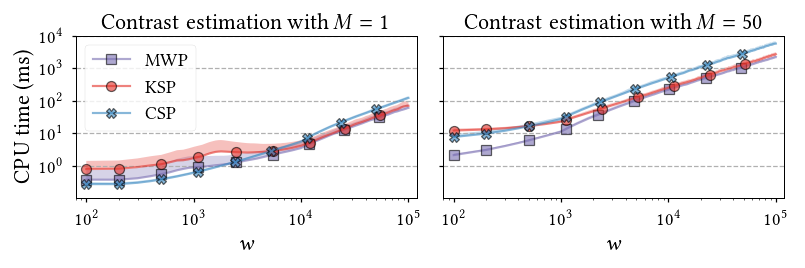

In [16]:
%matplotlib notebook

testIds = ['MWP', 'KSPsn', 'CSPn'] 
attributes = [("cpu", "mean"), ("cpu", "std")]

f, axarr = plt.subplots(1,2, figsize=(9,3), sharex=True, sharey=True)

plt.sca(axarr[0])
m = 1
i = 0
for testId in testIds: 
    data = masterdata[masterdata['testId'] == testId]
    data = data[data["M"] == m]
    subdata = data[data["refId"] == dict_corres[testId]]
    cutoffs = subdata.groupby("w")["cpu"].quantile([0.10, 0.90]).unstack(level=1)
    subdata = subdata.loc[((cutoffs.loc[subdata["w"], 0.10] < subdata["cpu"].values) & 
                           (subdata["cpu"].values < cutoffs.loc[subdata["w"], 0.90])).values]
    
    subdata = subdata.groupby(["refId", "testId", "M", "w"]).agg(["mean", "std"]).reset_index()
    subdata = subdata.sort_values("w")
    subdata[attributes] = subdata[attributes].rolling(100, 1).mean()
    
    plt.plot(subdata["w"], subdata["cpu"]["mean"],label=prettynames[testId], markevery=0.1, alpha=0.6, markersize=8,
             marker=styledictionary[testId]['marker'], color=styledictionary[testId]['color'],
            markeredgewidth=1, markeredgecolor="black")
    plt.fill_between(subdata["w"], subdata["cpu"]["mean"], 
                     subdata["cpu"]["mean"]+subdata["cpu"]["std"] ,
                     alpha=0.3, facecolor=styledictionary[testId]['color'])

    plt.ylabel("CPU time (ms)", fontsize = 18)
    plt.xlabel("$w$", fontsize=18)
    plt.legend(fontsize=15, ncol=1)
    plt.yscale("log")
    plt.xscale("log")
    plt.grid(axis="y", linestyle="--")
    
    plt.title("Contrast estimation with $M=%s$"%m, fontsize = 18)
    
    plt.xlim(0,100000)
    plt.ylim(0.01, 1000000)
    plt.yticks([1,10,100,1000,10000,100000,1000000])
    i += 1
  
plt.sca(axarr[1])
m = 50
i = 0
for testId in testIds: 
    data = masterdata[masterdata['testId'] == testId]
    data = data[data["M"] == m]
    subdata = data[data["refId"] == dict_corres[testId]]
    cutoffs = subdata.groupby("w")["cpu"].quantile([0.05, 0.95]).unstack(level=1)
    subdata = subdata.loc[((cutoffs.loc[subdata["w"], 0.05] < subdata["cpu"].values) & 
                           (subdata["cpu"].values < cutoffs.loc[subdata["w"], 0.95])).values]
    
    subdata = subdata.groupby(["refId", "testId", "M", "w"]).agg(["mean", "std"]).reset_index()
    subdata = subdata.sort_values("w")
    subdata[attributes] = subdata[attributes].rolling(10, 1).mean()
    
    plt.plot(subdata["w"], subdata["cpu"]["mean"],label=prettynames[testId], markevery=0.1, alpha=0.6, markersize=8,
             marker=styledictionary[testId]['marker'], color=styledictionary[testId]['color'], 
             markeredgewidth=1, markeredgecolor="black")
    plt.fill_between(subdata["w"], subdata["cpu"]["mean"], 
                     subdata["cpu"]["mean"]+subdata["cpu"]["std"] ,
                     alpha=0.3, facecolor=styledictionary[testId]['color'])
    
    plt.yscale("log")
    plt.xscale("log")
    plt.grid(axis="y", linestyle="--")
    plt.xlabel("$w$", fontsize=18)
    
    plt.title("Contrast estimation with $M=%s$"%m, fontsize = 18)
    
    plt.xlim(80,120000)
    plt.ylim(0.1, 10000)
    plt.yticks([1,10,100,1000,10000])
    plt.xticks([100,1000,10000,100000])
    
    i += 1

plt.tight_layout()

plt.savefig("plots/Fig8.pdf")